In [14]:
from deap import base, creator, tools
import random 

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

IND_SIZE = 10

toolbox = base.Toolbox()
toolbox.register("attribute", random.uniform, -5.12, 5.12)
toolbox.register(
    "individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=IND_SIZE
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def evaluate(individual):
    return (sum(individual),)


toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)


def main():
    pop = toolbox.population(n=50)
    CXPB, MUTPB, NGEN = 0.5, 0.2, 40

    # Evaluate the entire population
    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)

    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = [toolbox.clone(ind) for ind in offspring]

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        for ind in offspring:
            if not ind.fitness.valid:
                ind.fitness.values = toolbox.evaluate(ind)

        # The population is entirely replaced by the offspring
        pop[:] = offspring



    return pop


new_pop = main()

for ind in new_pop:
    print(f"Variable: {ind}\n Fitness: {ind.fitness.values}\n")



Variable: [-4.42544472583439, -7.596939355896197, -9.47714185772149, -7.960516676869714, -5.7904807295576655, -7.845420387868129, -4.194870525199509, -6.753387725007436, -11.929710165814317, -8.417305787356943]
 Fitness: (-74.39121793712579,)

Variable: [-4.767223460128733, -7.596939355896197, -9.551332742704234, -7.960516676869714, -5.144219949653986, -7.097162867250704, -4.9113780360086015, -7.199609904455336, -11.929710165814317, -8.417305787356943]
 Fitness: (-74.57539894613876,)

Variable: [-4.42544472583439, -7.596939355896197, -11.626614001330374, -7.960516676869714, -5.144219949653986, -7.276818733023387, -4.9113780360086015, -7.559849298483419, -10.04831359186991, -8.417305787356943]
 Fitness: (-74.96740015632692,)

Variable: [-4.42544472583439, -7.596939355896197, -11.626614001330374, -8.619351337159067, -5.144219949653986, -7.276818733023387, -4.9113780360086015, -6.0586394509194434, -10.04831359186991, -7.212956752596604]
 Fitness: (-72.92067593429195,)

Variable: [-4.42544

/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


## Plot The CMA-ES algorithm takes a population of one individual as argument

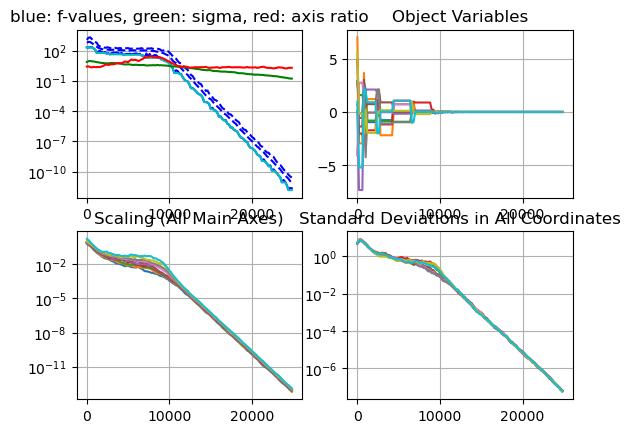

In [1]:
#    This file is part of DEAP.
#
#    DEAP is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    DEAP is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

import numpy

from deap import algorithms
from deap import base
from deap import benchmarks
from deap import cma
from deap import creator
from deap import tools

import matplotlib.pyplot as plt

# Problem size
N = 10
NGEN = 125

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("evaluate", benchmarks.rastrigin)

def main(verbose=True):
    # The cma module uses the numpy random number generator
    numpy.random.seed(64)

    # The CMA-ES algorithm takes a population of one individual as argument
    # The centroid is set to a vector of 5.0 see http://www.lri.fr/~hansen/cmaes_inmatlab.html
    # for more details about the rastrigin and other tests for CMA-ES    
    strategy = cma.Strategy(centroid=[5.0]*N, sigma=5.0, lambda_=20*N)
    toolbox.register("generate", strategy.generate, creator.Individual)
    toolbox.register("update", strategy.update)

    halloffame = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"

    # Objects that will compile the data
    sigma = numpy.ndarray((NGEN,1))
    axis_ratio = numpy.ndarray((NGEN,1))
    diagD = numpy.ndarray((NGEN,N))
    fbest = numpy.ndarray((NGEN,1))
    best = numpy.ndarray((NGEN,N))
    std = numpy.ndarray((NGEN,N))

    for gen in range(NGEN):
        # Generate a new population
        population = toolbox.generate()
        # Evaluate the individuals
        fitnesses = toolbox.map(toolbox.evaluate, population)
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        # Update the strategy with the evaluated individuals
        toolbox.update(population)

        # Update the hall of fame and the statistics with the
        # currently evaluated population
        halloffame.update(population)
        record = stats.compile(population)
        logbook.record(evals=len(population), gen=gen, **record)

        if verbose:
            print(logbook.stream)

        # Save more data along the evolution for latter plotting
        # diagD is sorted and sqrooted in the update method
        sigma[gen] = strategy.sigma
        axis_ratio[gen] = max(strategy.diagD)**2/min(strategy.diagD)**2
        diagD[gen, :N] = strategy.diagD**2
        fbest[gen] = halloffame[0].fitness.values
        best[gen, :N] = halloffame[0]
        std[gen, :N] = numpy.std(population, axis=0)

    # The x-axis will be the number of evaluations
    x = list(range(0, strategy.lambda_ * NGEN, strategy.lambda_))
    avg, max_, min_ = logbook.select("avg", "max", "min")
    plt.figure()
    plt.subplot(2, 2, 1)
    plt.semilogy(x, avg, "--b")
    plt.semilogy(x, max_, "--b")
    plt.semilogy(x, min_, "-b")
    plt.semilogy(x, fbest, "-c")
    plt.semilogy(x, sigma, "-g")
    plt.semilogy(x, axis_ratio, "-r")
    plt.grid(True)
    plt.title("blue: f-values, green: sigma, red: axis ratio")

    plt.subplot(2, 2, 2)
    plt.plot(x, best)
    plt.grid(True)
    plt.title("Object Variables")

    plt.subplot(2, 2, 3)
    plt.semilogy(x, diagD)
    plt.grid(True)
    plt.title("Scaling (All Main Axes)")

    plt.subplot(2, 2, 4)
    plt.semilogy(x, std)
    plt.grid(True)
    plt.title("Standard Deviations in All Coordinates")

    plt.show()

if __name__ == "__main__":
    main(False)